**Importing Useful Libraries**

In [1]:
import cv2
import numpy as np
from numpy.linalg import inv
import math
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.measure import structural_similarity as ssim

**Loading Raw and Original Images(Bayer Canon Images without Noise are used)**

In [2]:
images=[]
oimages=[]
for i in range(1,51,1):
    images.append(cv2.imread("./Raw/"+str(i)+".png"));
for i in range(1,51,1):
    oimages.append(cv2.imread("./Original/"+str(i)+".png"));

**Showing Raw Images**

Text(0.5,1,u'Image 4')

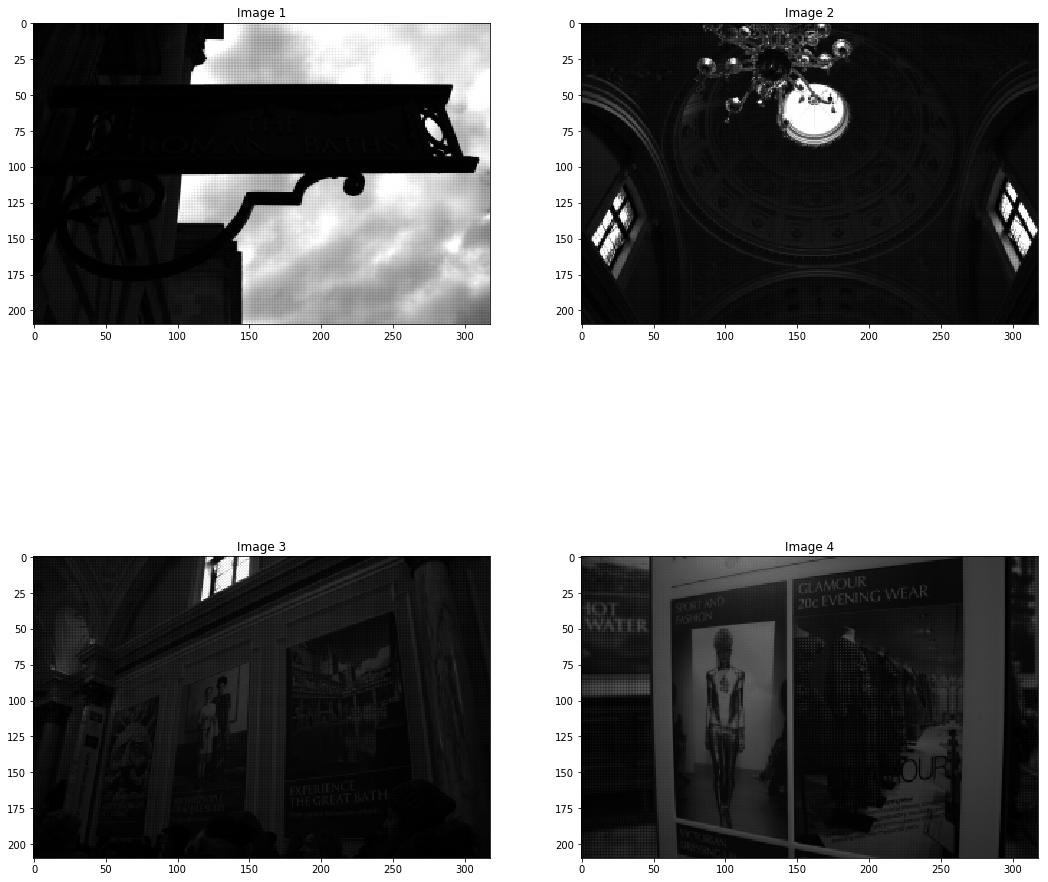

In [3]:
f0, ax0 = plt.subplots(2,2,figsize=(18,18))
ax0[0,0].imshow(images[0])
ax0[0,0].set_title("Image 1")
ax0[0,1].imshow(images[1])
ax0[0,1].set_title("Image 2")
ax0[1,0].imshow(images[2])
ax0[1,0].set_title("Image 3")
ax0[1,1].imshow(images[3])
ax0[1,1].set_title("Image 4")

*Raw image has 3 channels with same value for a pixel in 3 layers, so removing unnecessary information from the image. After this, Ist channel will only have pixels corresponding to Red color in Bayer filter, green in 2nd channel and blue in 3rd channel.*

In [4]:
for i in range(0,len(images),1):
    for x in range(1,images[i].shape[0],2):
        images[i][x,:,0]=0;
    for x in range(1,images[i].shape[1],2):
        images[i][:,x,0]=0;
 
    for x in range(0,images[i].shape[0],1):
        for y in range(0,images[i].shape[1],1):
            if (x%2==0 and y%2==0):
                images[i][x,y,1]=0;
            elif (x%2==1 and y%2==1):
                images[i][x,y,1]=0;
    
    for x in range(0,images[i].shape[0],2):
        images[i][x,:,2]=0;
    for x in range(0,images[i].shape[1],2):
        images[i][:,x,2]=0;
        

**Defining Demosaicing function. Bilinear Approach has been used for interpolation.**

In [5]:
def Demosaicing(img):
#For Red Layer
    
    for i in range(0,img.shape[0],2):
        for j in range(1,img.shape[1],2):
            if j+1<img.shape[1]:
                img[i,j,0]=int(math.ceil((img[i,j-1,0]/2.0)+(img[i,j+1,0]/2.0)));
    
    for i in range(1,img.shape[0],2):
        for j in range(0,img.shape[1],2):
            if i+1<img.shape[0]:
                img[i,j,0]=int(math.ceil((img[i-1,j,0]/2.0)+(img[i+1,j,0]/2.0)));
    
    for i in range(1,img.shape[0],2):
        for j in range(1,img.shape[1],2):
            if i+1<img.shape[0] and j+1<img.shape[1]:
                img[i,j,0]=int(math.ceil((img[i-1,j-1,0]/4.0)+(img[i-1,j+1,0]/4.0)+(img[i+1,j-1,0]/4.0)+(img[i+1,j+1,0]/4.0)));
    
    if img.shape[0]%2==0:
        img[img.shape[0]-1,:,0]=img[img.shape[0]-2,:,0]
    
    if img.shape[1]%2==0:
        img[:,img.shape[1]-1,0]=img[:,img.shape[1]-2,0]
    
    if img.shape[0]%2==0 and img.shape[1]%2==0:
        img[img.shape[0]-1,img.shape[1]-1,0]=img[img.shape[0]-2,img.shape[1]-2,0]

#For Green Layer
    
    for i in range(1,img.shape[0],2):
        for j in range(1,img.shape[1],2):
            if i+1<img.shape[0] and j+1<img.shape[1]:
                img[i,j,1]=int(math.ceil((img[i-1,j,1]/4.0)+(img[i,j+1,1]/4.0)+(img[i+1,j,1]/4.0)+(img[i,j-1,1]/4.0)));
    
    for i in range(2,img.shape[0],2):
        for j in range(2,img.shape[1],2):
            if i+1<img.shape[0] and j+1<img.shape[1]:
                img[i,j,1]=int(math.ceil((img[i-1,j,1]/4.0)+(img[i,j+1,1]/4.0)+(img[i+1,j,1]/4.0)+(img[i,j-1,1]/4.0)));
    
    img[0,0,1]=int(math.ceil(img[0,1,1]/2.0+img[1,0,1]/2.0))
    
    for j in range(2,img.shape[1]-1,2):
        img[0,j,1]=int(math.ceil((img[0,j-1,1]/3.0)+(img[0,j+1,1]/3.0)+(img[1,j,1]/3.0)))
    
    for i in range(2,img.shape[0]-1,2):
        img[i,0,1]=int(math.ceil((img[i-1,0,1]/3.0)+(img[i+1,0,1]/3.0)+(img[i,1,1]/3.0)))
    
    if img.shape[0]%2==0:
        img[img.shape[0]-1,img.shape[1]-1,1]=int(math.ceil((img[img.shape[0]-2,img.shape[1]-1,1]/2.0)+(img[img.shape[0]-1,img.shape[1]-2,1]/2.0)));
        for j in range(1,img.shape[1]-1,2):
            img[img.shape[0]-1,j,1]=int(math.ceil((img[img.shape[0]-1,j-1,1]/3.0)+(img[img.shape[0]-1,j+1,1]/3.0)+(img[img.shape[0]-2,j,1]/3.0)))
    else:
        img[img.shape[0]-1,0,1]=int(math.ceil((img[img.shape[0]-2,0,1]/2.0)+(img[img.shape[0]-1,1,1]/2.0)));
        for j in range(2,img.shape[1]-1,2):
            img[img.shape[0]-1,j,1]=int(math.ceil((img[img.shape[0]-1,j-1,1]/3.0)+(img[img.shape[0]-1,j+1,1]/3.0)+(img[img.shape[0]-1,j,1]/3.0)))
    
    if img.shape[1]%2==0:
        for i in range(1,img.shape[0]-1,2):
            img[i,img.shape[1]-1,1]=int(math.ceil((img[i-1,img.shape[1]-1,1]/3.0)+(img[i+1,img.shape[1]-1,1]/3.0)+(img[i,img.shape[1]-2,1]/3.0)))
    else:
        for j in range(2,img.shape[1]-1,2):
            img[i,img.shape[1]-1,1]=int(math.ceil((img[i-1,img.shape[1]-1,1]/3.0)+(img[i+1,img.shape[1]-1,1]/3.0)+(img[i,img.shape[1]-2,1]/3.0)))
#For Blue layer
    
    for i in range(1,img.shape[0],2):
        for j in range(2,img.shape[1],2):
            if j+1<img.shape[1]:
                img[i,j,2]=int(math.ceil((img[i,j-1,2]/2.0)+(img[i,j+1,2]/2.0)));
    
    for i in range(2,img.shape[0],2):
        for j in range(1,img.shape[1],2):
            if i+1<img.shape[0]:
                img[i,j,2]=int(math.ceil((img[i-1,j,2]/2.0)+(img[i+1,j,2]/2.0)));
    
    for i in range(2,img.shape[0],2):
        for j in range(2,img.shape[1],2):
            if i+1<img.shape[0] and j+1<img.shape[1]:
                img[i,j,2]=int(math.ceil((img[i-1,j-1,2]/4.0)+(img[i-1,j+1,2]/4.0)+(img[i+1,j-1,2]/4.0)+(img[i+1,j+1,2]/4.0)));
    
    img[0,:,2]=img[1,:,2]
    img[:,0,2]=img[:,1,2]
    img[0,0,2]=img[1,1,2]
    
    return img;

**Generating Demosaiced image, and storing them in "Predicted" folder**

In [6]:
Images=[]
for i in images: 
    Images.append(Demosaicing(i))
for i in range(0,len(Images),1):
    cv2.imwrite("Predicted/"+str(i+1)+".png",cv2.cvtColor(Images[i], cv2.COLOR_BGR2RGB));

**Defining function for Mean square error and PSNR computation**

In [7]:
def mse(o,p):
    error=0.0;
    for k in range(0,o.shape[2],1):
        for i in range(0,o.shape[0],1):
            for j in range(0,o.shape[1],1):
                e=o[i,j,k]-p[i,j,k];
                error+=e*e;
    return error/(o.shape[0]*o.shape[1]*o.shape[2])

def psnr(mse):
	return 10*math.log10((255*255)/mse)

**Showing some Demosaiced Images**

Text(0.5,1,u'Image 4')

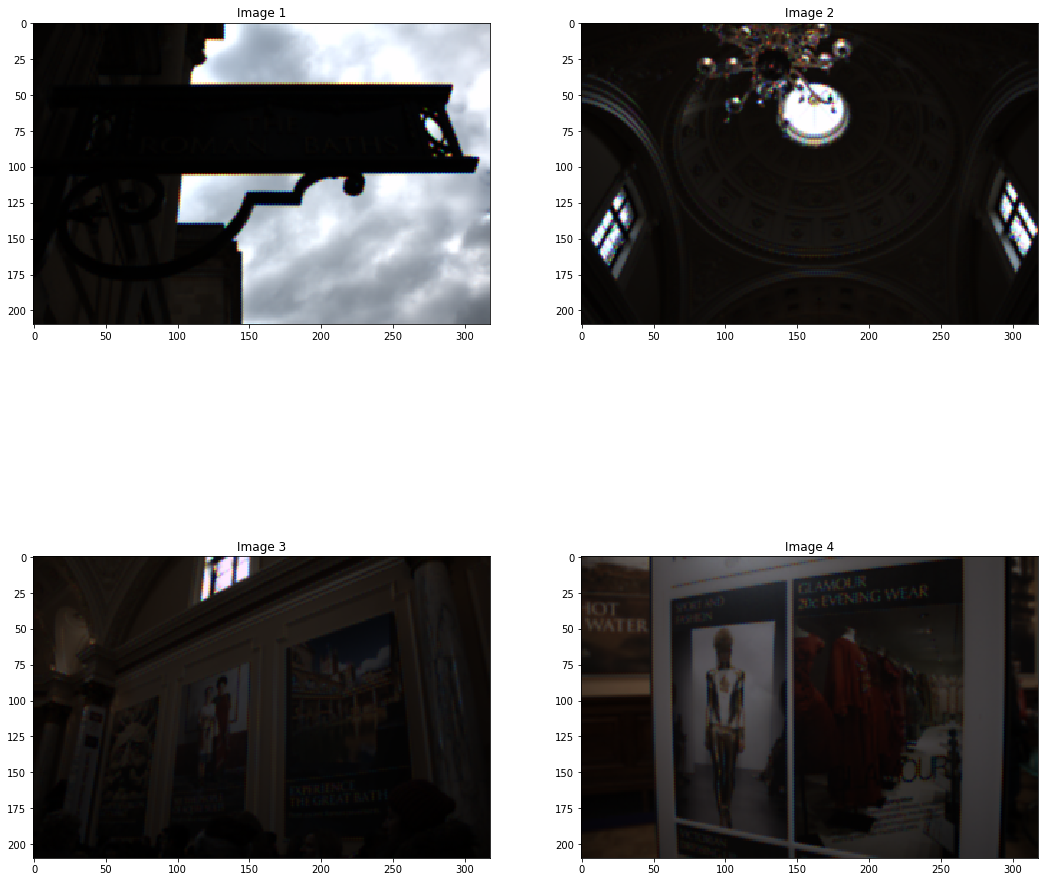

In [8]:
f, ax = plt.subplots(2,2,figsize=(18,18))
ax[0,0].imshow(Images[0])
ax[0,0].set_title("Image 1")
ax[0,1].imshow(Images[1])
ax[0,1].set_title("Image 2")
ax[1,0].imshow(Images[2])
ax[1,0].set_title("Image 3")
ax[1,1].imshow(Images[3])
ax[1,1].set_title("Image 4")

**Computing PSNR for Demosaiced images with respect to original rgb images.**

In [9]:
for i in range(0,50,1):
    print("PSNR for image "+str(i+1)+".png "+str(psnr(mse(oimages[i],Images[i]))));

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in ubyte_scalars
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys


PSNR for image 1.png 32.3703558699
PSNR for image 2.png 33.9918423722
PSNR for image 3.png 33.0586027754
PSNR for image 4.png 33.2964821832
PSNR for image 5.png 32.9298949604
PSNR for image 6.png 34.3487061743
PSNR for image 7.png 31.5508168526
PSNR for image 8.png 32.4178947955
PSNR for image 9.png 36.7462271327
PSNR for image 10.png 31.2733540412
PSNR for image 11.png 36.6879419927
PSNR for image 12.png 33.7130275522
PSNR for image 13.png 32.8237341544
PSNR for image 14.png 32.8273201244
PSNR for image 15.png 37.4466333003
PSNR for image 16.png 34.8987759224
PSNR for image 17.png 31.8098021821
PSNR for image 18.png 32.7029270101
PSNR for image 19.png 31.3235929735
PSNR for image 20.png 32.4590380302
PSNR for image 21.png 36.2436070836
PSNR for image 22.png 36.1082759954
PSNR for image 23.png 31.6628778151
PSNR for image 24.png 33.118999383
PSNR for image 25.png 30.5483672877
PSNR for image 26.png 32.2280343004
PSNR for image 27.png 31.8205454778
PSNR for image 28.png 33.2958733194
PS

**Defining Bilateral filter**

In [10]:
def bilateral_filter(X_matrix,size,sigma_d,sigma_r):
	X=np.zeros((len(X_matrix),len(X_matrix[0])))
	center=size//2    
	for j in range(center,len(X_matrix)-center,1):
		for k in range(center,len(X_matrix[0])-center,1):
			temp=0;
			w_sum=0;
			for m in range(-center,center+1,1):
				for n in range(-center,center+1,1):
					w=math.exp(-(((m)**2+(n)**2)/(2*sigma_d*sigma_d))-((abs(X_matrix[j+m][k+n]-X_matrix[j][k]))/(2*sigma_r*sigma_r)))
					temp+=X_matrix[j+m][k+n]*w;
					w_sum+=w;
			X[j][k]=temp//(w_sum);
	return X;

**Applying Bilateral filter on Demosaiced images**

In [11]:
bImages=[]
for i in Images:
    i[:,:,0]=bilateral_filter(i[:,:,0],3,2,0.25)
    i[:,:,1]=bilateral_filter(i[:,:,1],3,2,0.25)
    i[:,:,2]=bilateral_filter(i[:,:,2],3,2,0.25)
    bImages.append(i);

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.


**Storing Images are after applying Bilateral filter.**

In [14]:
for i in range(0,len(bImages),1):
    cv2.imwrite("Bilateral/"+str(i+1)+".png",cv2.cvtColor(bImages[i], cv2.COLOR_BGR2RGB));

**Computing PSNR for demosaiced images after applying Bilateral filter.**

In [15]:
for i in range(0,50,1):
    print("PSNR for image "+str(i+1)+".png "+str(psnr(mse(oimages[i],bImages[i]))));

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in ubyte_scalars
  


PSNR for image 1.png 32.3019073393
PSNR for image 2.png 33.8784395515
PSNR for image 3.png 33.0179565487
PSNR for image 4.png 33.1660881306
PSNR for image 5.png 32.8016886162
PSNR for image 6.png 34.258943899
PSNR for image 7.png 31.4738734295
PSNR for image 8.png 32.3492977836
PSNR for image 9.png 36.5518419328
PSNR for image 10.png 31.2576435794
PSNR for image 11.png 36.4150692009
PSNR for image 12.png 33.587784715
PSNR for image 13.png 32.748417974
PSNR for image 14.png 32.7451317563
PSNR for image 15.png 37.2183751361
PSNR for image 16.png 34.6730516362
PSNR for image 17.png 31.7462454394
PSNR for image 18.png 32.5989152007
PSNR for image 19.png 31.2648521906
PSNR for image 20.png 32.3335352976
PSNR for image 21.png 36.1687042534
PSNR for image 22.png 35.9149611846
PSNR for image 23.png 31.5596740442
PSNR for image 24.png 32.982622162
PSNR for image 25.png 30.4492668113
PSNR for image 26.png 32.155509109
PSNR for image 27.png 31.7467817297
PSNR for image 28.png 33.2092577138
PSNR f

**After applying Bilateral filter,PSNR of Images reduced.**